In [1]:
# load up spark
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from pyspark import SparkContext, SparkConf
conf = (SparkConf().setMaster("local[3]").setAppName("My app"))
sc = SparkContext(conf=conf)

In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4,
                    threshold=10000,
                    linewidth=100)
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

In [3]:
from textunit import TextUnit
from twitter_dm.utility.general_utils import read_grouped_by_newline_file
from constraints import get_id_and_value_map
import io
import sys
import codecs
from constraints import IDENTITY_PREFIX, SENTWORD_PREFIX
from collections import defaultdict

sys.stdout = codecs.getwriter('utf-8')(sys.stdout)

# Simulate Association Model

In [3]:
# A simple test data set
import numpy as np
from user import User
import numpy as np
from stat_util import softmax
import textunit
reload(textunit)
N_USERS = 5000
N_IDENTITIES = 100
# Log-normal distribution based on data / prior work
N_DOCS_PER_USER = np.exp(np.random.normal(4.86,1.22,N_USERS))+175


# fake association model data
fake_data_mu = np.random.normal(5,1,N_IDENTITIES)
fake_data_sigma = np.identity(np.shape(fake_data_mu)[0])
fake_data_sigma[0,1] = .8
fake_data_sigma[1,0] = .8
fake_etas =  np.random.multivariate_normal(fake_data_mu, fake_data_sigma, N_USERS)

users = [User(u,[]) for u in range(N_USERS)]
print 'getting users'
for user_it in range(N_USERS):
    theta = softmax(fake_etas[user_it])
    if user_it % 1000 == 0:
        print 'User: ', user_it
    n_docs = N_DOCS_PER_USER[user_it]
    users[user_it].training_vector = np.zeros(N_IDENTITIES)
    users[user_it].test_vector = np.zeros(N_IDENTITIES)
    identities = np.random.multinomial(n_docs, theta)
    users[user_it].training_vector += identities

getting users
User:  0
User:  1000
User:  2000
User:  3000
User:  4000


In [5]:
N_DOCS_PER_USER.max()

9361.2780480690471

In [106]:
tv = np.array([u.training_vector for u in users])
tv.sum(axis=0)

array([3928.000000, 15908.000000, 23562.000000, 39253.000000, 58918.000000, 38552.000000,
       27169.000000, 10604.000000, 7686.000000, 16355.000000, 4978.000000, 3026.000000,
       30180.000000, 7865.000000, 14263.000000, 8038.000000, 71867.000000, 13530.000000,
       18048.000000, 27138.000000, 8284.000000, 55281.000000, 10951.000000, 3496.000000,
       94258.000000, 16518.000000, 25517.000000, 12770.000000, 6330.000000, 50027.000000,
       48336.000000, 56328.000000, 10021.000000, 4792.000000, 15113.000000, 12143.000000,
       34372.000000, 6751.000000, 14650.000000, 28279.000000, 7146.000000, 14325.000000,
       4980.000000, 11328.000000, 5908.000000, 16729.000000, 71213.000000, 15911.000000,
       5858.000000, 3296.000000, 1509.000000, 23990.000000, 26446.000000, 27348.000000,
       11251.000000, 2233.000000, 37730.000000, 3912.000000, 73357.000000, 4778.000000,
       12896.000000, 19836.000000, 2045.000000, 7227.000000, 3180.000000, 2185.000000, 6363.000000,
       734

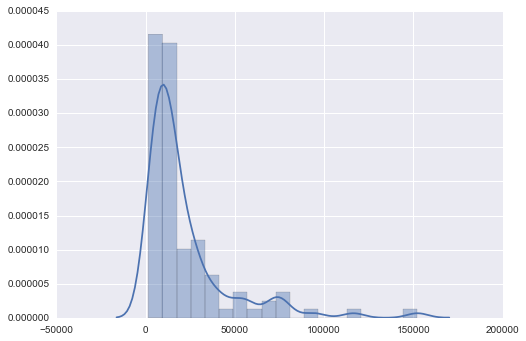

In [107]:

import seaborn as sns
%matplotlib inline
sns.set()
sns.distplot(tv.sum(axis=0))

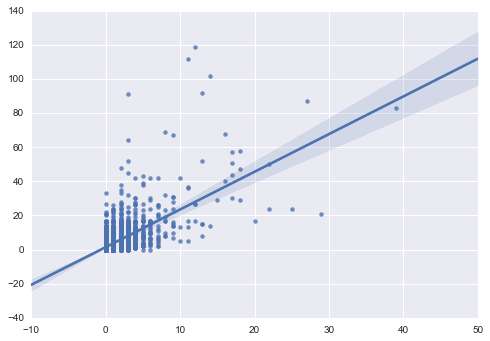

In [108]:
sns.regplot(tv[:,0],tv[:,1])

In [113]:
import sentiment_model
import association_model

print 'init for association model'
assoc_model = association_model.AssociationModel(users,N_IDENTITIES)
for i in range(50):
    assoc_model.iterate(sc,n_partitions=3)

init for association model
ASSOC MODEL LL TRAINING, TEST  -1166866.77141 , 0.0
ASSOC MODEL LL TRAINING, TEST  -967202.789568 , 0.0
ASSOC MODEL LL TRAINING, TEST  -890346.145029 , 0.0
ASSOC MODEL LL TRAINING, TEST  -851410.951724 , 0.0
ASSOC MODEL LL TRAINING, TEST  -826607.415471 , 0.0
ASSOC MODEL LL TRAINING, TEST  -810519.539392 , 0.0
ASSOC MODEL LL TRAINING, TEST  -798805.133803 , 0.0
ASSOC MODEL LL TRAINING, TEST  -789494.189701 , 0.0
ASSOC MODEL LL TRAINING, TEST  -782832.964061 , 0.0
ASSOC MODEL LL TRAINING, TEST  -777291.979404 , 0.0
ASSOC MODEL LL TRAINING, TEST  -772048.893364 , 0.0
ASSOC MODEL LL TRAINING, TEST  -768225.619445 , 0.0
ASSOC MODEL LL TRAINING, TEST  -765143.568993 , 0.0
ASSOC MODEL LL TRAINING, TEST  -766666.283733 , 0.0
ASSOC MODEL LL TRAINING, TEST  -765520.331089 , 0.0
ASSOC MODEL LL TRAINING, TEST  -763851.93844 , 0.0
ASSOC MODEL LL TRAINING, TEST  -762232.112301 , 0.0
ASSOC MODEL LL TRAINING, TEST  -760961.657171 , 0.0
ASSOC MODEL LL TRAINING, TEST  -755010

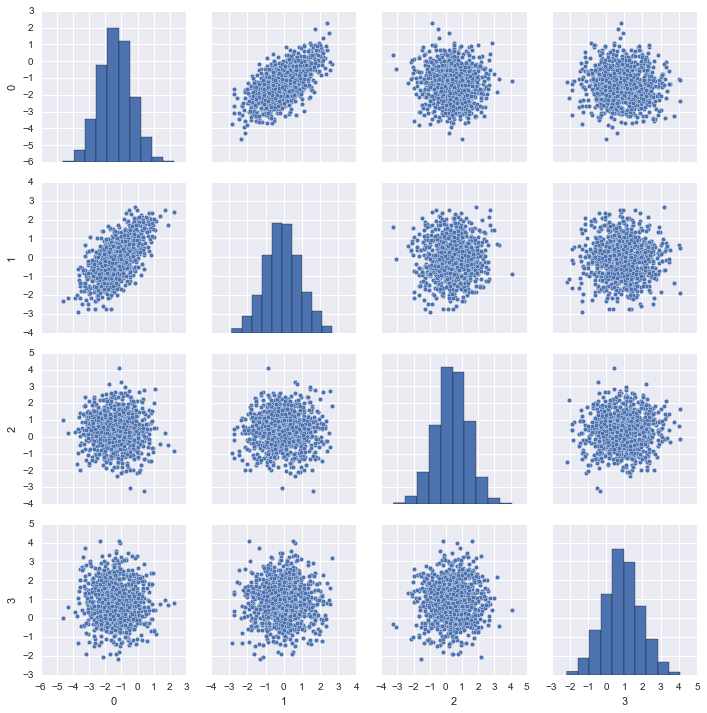

In [115]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV, ledoit_wolf

sns.set()
sns.pairplot(pd.DataFrame(assoc_model.eta[:1000,:4]))

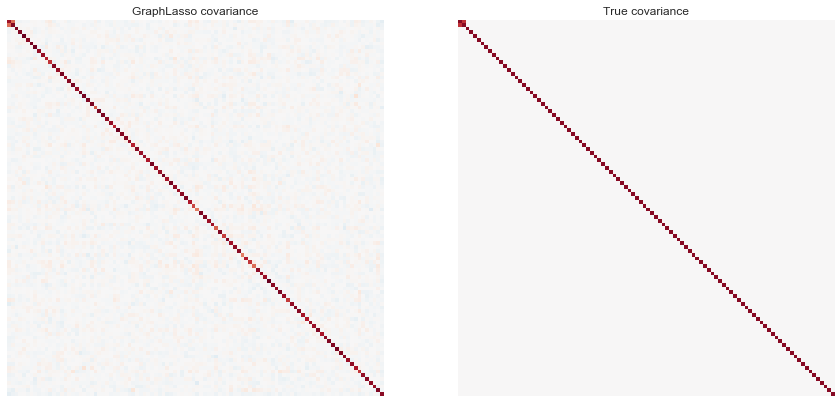

In [116]:
d = assoc_model.eta
model = GraphLassoCV()
model.fit(d)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(d)
lw_prec_ = linalg.inv(lw_cov_)

plt.figure(figsize=(25, 25))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('GraphLasso', cov_), ('True', fake_data_sigma)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)

# Simulate Sentiment Model

In [239]:
# fake sentiment model data
# Draw user's sentiment views from mu, sigma (only model E)
fake_identity_to_values = {}
fake_id_to_index = {}
fake_index_to_id = {}
fake_sent_users = np.zeros((N_USERS, N_IDENTITIES))
for i in range(N_IDENTITIES):
    # This is where the model will take it's priors from, so lets confuse it a little
    fake_identity_to_values["i_"+str(i)] = [0,0,0]
    fake_index_to_id[i] ="i_"+str(i)
    fake_id_to_index["i_"+str(i)] = i
    fake_sent_users[:,i] = np.random.normal(i%5, 1, N_USERS)
    

In [240]:
print 'getting users'
for user_it in range(N_USERS):
    if user_it % 1000 == 0:
        print 'User: ', user_it

    # for each document
    for identity_it,count in enumerate(users[user_it].training_vector):
        for k in range(int(count)):
            #pick an identity
            tweet = textunit.FakeTextUnit()
            sd_val = np.random.uniform(0,4)
            tweet.add_fake_constraint(fake_index_to_id[identity_it],fake_sent_users[user_it,identity_it],sd_val)
            users[user_it].add_training_tweet(tweet)

getting users
User:  0
User:  1000
User:  2000
User:  3000
User:  4000


In [242]:
# because pyspark uses pickle, which is really slow for this data, we cache data on disk ourselves using msgpack
# in practice this is infinitely more efficient, although theoretically it should be slower
import msgpack
spl_inds = np.array_split(np.array(range(N_USERS)),8)

last_spl = 0
for i, inds in enumerate(spl_inds):
    max_spl_inds = last_spl + len(inds)
    msgpack.dump([u.training_id_to_tweets for u in users[last_spl:max_spl_inds]], open( 'tr_inds'+str(i)+'.mpack',"wb"))

In [243]:
import sentiment_model
sm = sentiment_model.SentimentModel(N_USERS,fake_index_to_id,fake_identity_to_values,kappa=100,nu=1000)

done computing mu0
got phi


In [247]:
print 'SENT MU: '
for k in range(10):
    print '\t updating sentiment'
    sm.iterate(sc,spl_inds,"",fake_id_to_index, True)

SENT MU: 
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment
	 updating sentiment


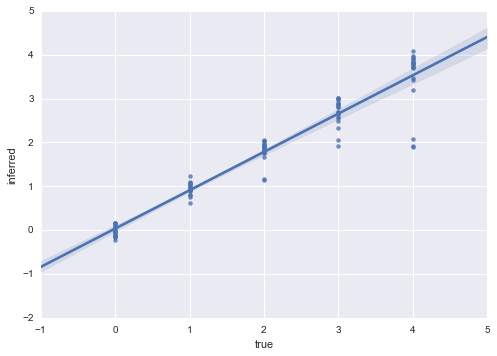

In [253]:
sns.regplot('true','inferred',
            pd.DataFrame([(int(x[2:-1])% 5,sm.mu[v]) for x,v in sm.ids_to_index.items() if x[-1] == 'e'], columns=['true','inferred']))